In [92]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os 
import re
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from datasets import load_dataset

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import warnings
warnings.filterwarnings('ignore')

In [2]:
class TextPreprocessor:
    def __init__(self, use_stemming=True, remove_stopwords=True):
        self.use_stemming = use_stemming
        self.remove_stopwords = remove_stopwords
        self.stemmer = PorterStemmer() if use_stemming else None
        self.stop_words = set(stopwords.words('english')) if remove_stopwords else set()
        
    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'<[^>]+>', '', text)
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def tokenize_and_preprocess(self, text):
        text = self.clean_text(text)
        tokens = word_tokenize(text)
        
        if self.remove_stopwords:
            tokens = [token for token in tokens if token not in self.stop_words]
        
        if self.use_stemming:
            tokens = [self.stemmer.stem(token) for token in tokens]
        
        return tokens
    
    def preprocess_texts(self, texts):
        return [' '.join(self.tokenize_and_preprocess(text)) for text in texts]

In [3]:
class BagOfWordsModel:
    def __init__(self, max_features=10000, use_tfidf=True):
        self.max_features = max_features
        self.use_tfidf = use_tfidf
        
        if use_tfidf:
            self.vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
        else:
            self.vectorizer = CountVectorizer(max_features=max_features, stop_words='english')
        
        self.classifier = LogisticRegression(random_state=42, max_iter=1000)
        
    def fit(self, texts, labels):
        X = self.vectorizer.fit_transform(texts)
        self.classifier.fit(X, labels)   
        return self
    
    def predict(self, texts):
        X = self.vectorizer.transform(texts)
        return self.classifier.predict(X)
    
    def predict_proba(self, texts):
        X = self.vectorizer.transform(texts)
        return self.classifier.predict_proba(X)

In [4]:
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [6]:
ds = load_dataset("stanfordnlp/imdb")

In [7]:
X_train = ds['train']['text']
X_test = ds['test']['text']

y_train = ds['train']['label']
y_test = ds['test']['label']

In [8]:
len(X_train), len(X_test)

(25000, 25000)

In [9]:
len(y_train), len(y_test)

(25000, 25000)

In [10]:
train_df = pd.DataFrame({
    'text': X_train,
    'sentiment': y_train
})

test_df = pd.DataFrame({
    'text': X_test,
    'sentiment': y_test
})

In [11]:
test_df.shape

(25000, 2)

In [12]:
train_df.shape

(25000, 2)

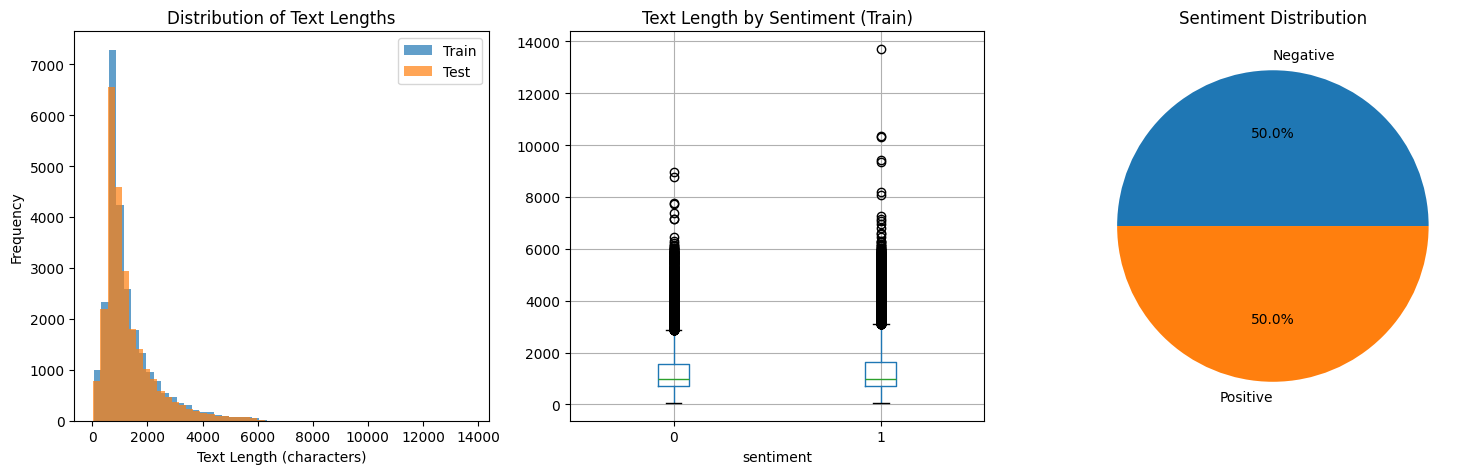

In [13]:
train_df['text_length'] = train_df['text'].str.len()
test_df['text_length'] = test_df['text'].str.len()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(train_df['text_length'], bins=50, alpha=0.7, label='Train')
plt.hist(test_df['text_length'], bins=50, alpha=0.7, label='Test')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.legend()

plt.subplot(1, 3, 2)
train_df.boxplot(column='text_length', by='sentiment', ax=plt.gca())
plt.title('Text Length by Sentiment (Train)')
plt.suptitle('')

plt.subplot(1, 3, 3)
sentiment_counts = train_df['sentiment'].value_counts()
plt.pie(sentiment_counts.values, labels=['Negative', 'Positive'], autopct='%1.1f%%')
plt.title('Sentiment Distribution')

plt.tight_layout()
plt.show()

In [14]:
preprocessor = TextPreprocessor()

train_texts_clean = preprocessor.preprocess_texts(X_train)
test_texts_clean = preprocessor.preprocess_texts(X_test)

print("Original:", X_train[0][:200] + "...")
print("Preprocessed:", train_texts_clean[0][:200] + "...")

Original: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev...
Preprocessed: rent curiousyellow video store controversi surround first releas also heard first seiz us custom ever tri enter countri therefor fan film consid controversi realli see myselfth plot center around youn...


In [15]:
bow_model = BagOfWordsModel(max_features=10000, use_tfidf=True)
bow_model.fit(train_texts_clean, y_train)

bow_train_pred = bow_model.predict(train_texts_clean)
bow_test_pred = bow_model.predict(test_texts_clean)
bow_test_proba = bow_model.predict_proba(test_texts_clean)

In [16]:
acc = bow_test_pred == y_test
sum(acc == True)/len(y_test)

0.8722

In [77]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_length=512):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        tokens = text.split()[:self.max_length]
        indices = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]
        
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

In [78]:
def collate_fn(batch):
    texts, labels = zip(*batch)
    texts = pad_sequence(texts, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    return texts, labels

In [79]:
class VocabBuilder:
    def __init__(self, min_freq=2):
        self.min_freq = min_freq
        self.vocab = {'<PAD>': 0, '<UNK>': 1}
        self.word_counts = Counter()
        
    def build_vocab(self, texts):
        for text in texts:
            self.word_counts.update(text.split())
        
        idx = 2
        for word, count in self.word_counts.items():
            if count >= self.min_freq:
                self.vocab[word] = idx
                idx += 1
        
        print(f"Vocabulary size: {len(self.vocab)}")
        return self.vocab

In [80]:
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )
        
    def forward(self, x, src_key_padding_mask=None):
        return self.transformer(x, src_key_padding_mask=src_key_padding_mask)

In [82]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=8, num_layers=2, 
                 dim_feedforward=256, dropout=0.1, num_classes=2, max_seq_len=512):
        super().__init__()
        
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0) 
        self.pos_encoding = nn.Embedding(max_seq_len, d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            activation='gelu' 
        )
        
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes)
        )
        
        self.init_weights()
        
    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight' in name and param.dim() > 1:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
        
    def forward(self, x):
        batch_size, seq_len = x.size()
        
        padding_mask = (x == 0)
        
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)
        
        x = self.embedding(x) * math.sqrt(self.d_model)
        x = x + self.pos_encoding(positions)
        
        x = self.transformer(x, src_key_padding_mask=padding_mask)
        
        mask = (~padding_mask).float().unsqueeze(-1)
        pooled = (x * mask).sum(dim=1) / (mask.sum(dim=1) + 1e-9) 
        
        return self.classifier(pooled)

In [83]:
vocab_builder = VocabBuilder(min_freq=2)
vocab = vocab_builder.build_vocab(train_texts_clean)

Vocabulary size: 39115


In [23]:
#print(vocab)

In [85]:
train_dataset = IMDBDataset(train_texts_clean, y_train, vocab, max_length=256)
test_dataset = IMDBDataset(test_texts_clean, y_test, vocab, max_length=256)

In [86]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

In [87]:
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [98]:
device = 'cpu'

model = TransformerClassifier(
    vocab_size=len(vocab),
    d_model=128,
    nhead=8,
    num_layers=3,
    dim_feedforward=256,
    dropout=0.1
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [95]:
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 5,470,210


In [96]:
def train_transformer(model, train_loader, val_loader, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pred = output.argmax(dim=1)
            train_correct += pred.eq(target).sum().item()
            train_total += target.size(0)
            
            if batch_idx % 50 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}')
        
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
                pred = output.argmax(dim=1)
                val_correct += pred.eq(target).sum().item()
                val_total += target.size(0)
        
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total
        
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 60)
        
        scheduler.step()
    
    return train_losses, val_losses, train_accuracies, val_accuracies

In [99]:
train_losses, val_losses, train_accuracies, val_accuracies = train_transformer(
    model, train_loader, val_loader, num_epochs=8
)

Epoch 1/8, Batch 0/625, Loss: 0.8668
Epoch 1/8, Batch 50/625, Loss: 0.5362
Epoch 1/8, Batch 100/625, Loss: 0.1666
Epoch 1/8, Batch 150/625, Loss: 0.3830
Epoch 1/8, Batch 200/625, Loss: 0.2847
Epoch 1/8, Batch 250/625, Loss: 0.2781
Epoch 1/8, Batch 300/625, Loss: 0.3478
Epoch 1/8, Batch 350/625, Loss: 0.4255
Epoch 1/8, Batch 400/625, Loss: 0.2040
Epoch 1/8, Batch 450/625, Loss: 0.4189
Epoch 1/8, Batch 500/625, Loss: 0.2073
Epoch 1/8, Batch 550/625, Loss: 0.3573
Epoch 1/8, Batch 600/625, Loss: 0.1952
Epoch 1/8:
Train Loss: 0.3785, Train Acc: 83.84%
Val Loss: 0.2966, Val Acc: 88.16%
------------------------------------------------------------
Epoch 2/8, Batch 0/625, Loss: 0.1535
Epoch 2/8, Batch 50/625, Loss: 0.1692
Epoch 2/8, Batch 100/625, Loss: 0.2231
Epoch 2/8, Batch 150/625, Loss: 0.4749
Epoch 2/8, Batch 200/625, Loss: 0.0521
Epoch 2/8, Batch 250/625, Loss: 0.1844
Epoch 2/8, Batch 300/625, Loss: 0.0853
Epoch 2/8, Batch 350/625, Loss: 0.1289
Epoch 2/8, Batch 400/625, Loss: 0.1207
Epoc

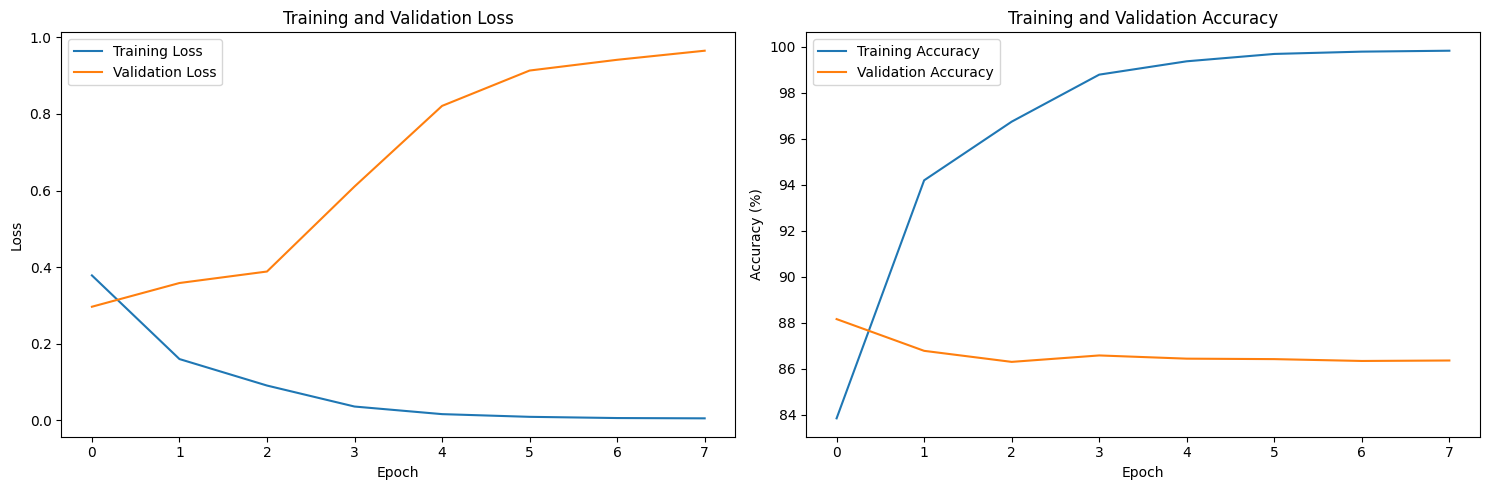

In [100]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [101]:
def evaluate_transformer(model, test_loader):
    model.eval()
    predictions = []
    probabilities = []
    true_labels = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prob = F.softmax(output, dim=1)
            pred = output.argmax(dim=1)
            
            predictions.extend(pred.cpu().numpy())
            probabilities.extend(prob.cpu().numpy())
            true_labels.extend(target.cpu().numpy())
    
    return np.array(predictions), np.array(probabilities), np.array(true_labels)

transformer_pred, transformer_proba, true_test_labels = evaluate_transformer(model, test_loader)

In [106]:
def calculate_metrics(y_true, y_pred, y_proba, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba[:, 1])
    
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))
    
    return accuracy, auc

In [103]:
bow_accuracy, bow_auc = calculate_metrics(
    y_test, bow_test_pred, bow_test_proba, "Bag of Words"
)

transformer_accuracy, transformer_auc = calculate_metrics(
    true_test_labels, transformer_pred, transformer_proba, "Transformer"
)


Bag of Words Results:
Accuracy: 0.8722
AUC-ROC: 0.9462

Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.87      0.87     12500
    Positive       0.87      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000


Transformer Results:
Accuracy: 0.8337
AUC-ROC: 0.9035

Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.85      0.84     12500
    Positive       0.85      0.82      0.83     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



In [104]:
results_df = pd.DataFrame({
    'Model': ['Bag of Words', 'Transformer'],
    'Accuracy': [bow_accuracy, transformer_accuracy],
    'AUC-ROC': [bow_auc, transformer_auc]
})

print(results_df.to_string(index=False))

       Model  Accuracy  AUC-ROC
Bag of Words   0.87220 0.946216
 Transformer   0.83368 0.903476


<Axes: >

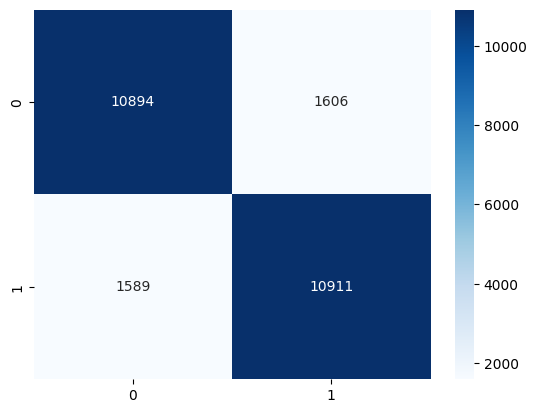

In [138]:
from sklearn.metrics import confusion_matrix
cm_bow = confusion_matrix(y_test, bow_test_pred)
cm_transformer = confusion_matrix(true_test_labels, transformer_pred)

sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Blues')

<Axes: >

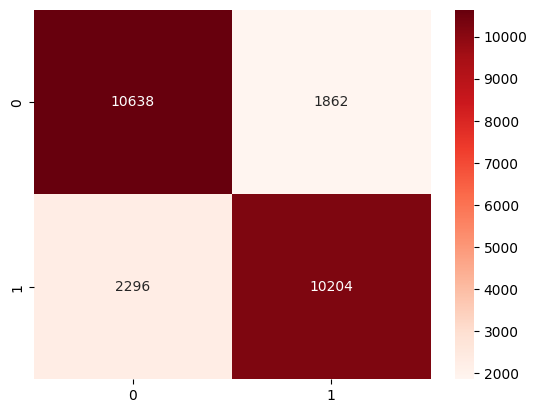

In [137]:
sns.heatmap(cm_transformer, annot=True, fmt='d', cmap='Reds')

In [145]:
len(bow_model.vectorizer.vocabulary_)

10000

In [146]:
sum(p.numel() for p in model.parameters())

5470210

In [148]:
feature_names = bow_model.vectorizer.get_feature_names_out()
coefficients = bow_model.classifier.coef_[0]
feature_importance = list(zip(feature_names, coefficients))
feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)

positive_features = [f for f in feature_importance if f[1] > 0][:10]
for feature, coef in positive_features:
    print(f"{feature}: {coef:.4f}")
print(" - - - ")
negative_features = [f for f in feature_importance if f[1] < 0][:10]
for feature, coef in negative_features:
    print(f"{feature}: {coef:.4f}")

great: 6.5539
excel: 6.2821
best: 4.8073
perfect: 4.7792
enjoy: 4.7076
favorit: 4.7048
love: 4.5559
beauti: 3.8688
amaz: 3.6458
definit: 3.5661
 - - - 
worst: -8.8996
wast: -7.6651
aw: -6.7863
bad: -6.6329
bore: -5.9427
poor: -5.3440
noth: -4.9961
wors: -4.8866
disappoint: -4.7224
terribl: -4.5872


In [157]:
import sys
bow_memory = sys.getsizeof(bow_model.vectorizer.vocabulary_) / 1024 / 1024  
transformer_memory = sum(p.numel() * 4 for p in model.parameters()) / 1024 / 1024

print(f"bow: {bow_memory:.1f} MB")
print(f" t: {transformer_memory:.1f} MB")
print(f" ratio {transformer_memory/bow_memory:.1f}x")

bow: 3.7 MB
 t: 20.9 MB
 ratio 5.7x
